# Bachelors thesis' analyses

*This Jupyter notebook is for the analyses and model building for Riku Laine's bachelors thesis*

**Contents**

1. [Compas]()
* [Creation of synthetic data]()
* [Implementation of competing algorithm]()
* [Implementation of our model]()
* [Comparisons and other validation analysis??]()

*etc etc...*

## COMPAS data

*The following data filtering procedure follows the one described in the [ProPublica methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).*

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
%matplotlib inline

# Read file
compas_raw = pd.read_csv("../data/compas-scores-two-years.csv")

# Check dimensions, number of rows should be 7214
compas_raw.shape

(7214, 53)

In [2]:
# Select columns
compas = compas_raw[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count'
                     , 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]

# Subset values
compas = compas.query('days_b_screening_arrest <= 30 and \
                      days_b_screening_arrest >= -30 and \
                      is_recid != -1 and \
                      c_charge_degree != "O"')

# Drop row if score_text is na
compas = compas[compas.score_text.notnull()]

compas.shape

(6172, 13)

In [3]:
out = pd.to_datetime(compas.c_jail_out, format="%Y-%m-%d %H:%M:%S")
in_ = pd.to_datetime(compas.c_jail_in,  format="%Y-%m-%d %H:%M:%S")

compas['length_of_stay'] = (out - in_).astype('timedelta64[D]')

# Correlation should be 0.2073297, but R uses n-1 
# as denominator in variance. Reference:
# https://stackoverflow.com/questions/53404367/why-pearson-correlation-is-different-between-tensorflow-and-scipy
print(compas[['length_of_stay', 'decile_score']].corr())

print(np.corrcoef(compas.length_of_stay, compas.decile_score))

from scipy.stats import pearsonr

pearsonr(compas.length_of_stay, compas.decile_score)

                length_of_stay  decile_score
length_of_stay        1.000000      0.207478
decile_score          0.207478      1.000000
[[1.         0.20747808]
 [0.20747808 1.        ]]


(0.2074780847803181, 5.439585463018677e-61)

In [4]:
print(compas.age_cat.value_counts())

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64


In [5]:
print(compas.race.value_counts())

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


In [6]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [7]:
compas.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [8]:
tab = compas.groupby(['sex', 'race']).size()
tab.unstack()

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285

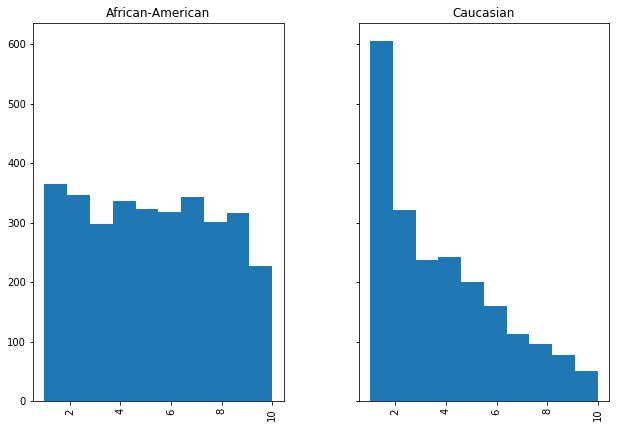

In [9]:
fig = compas.query("race in ['Caucasian', 'African-American']").hist("decile_score", by = "race",
                                                                     figsize=(10,7), sharey=True,
                                                                    grid = True)

0                    1  \
age                                       69                   34   
c_charge_degree                            F                    F   
race                                   Other     African-American   
age_cat                      Greater than 45              25 - 45   
score_text                               Low                  Low   
sex                                     Male                 Male   
priors_count                               0                    0   
days_b_screening_arrest                   -1                   -1   
decile_score                               1                    3   
is_recid                                   0                    1   
two_year_recid                             0                    1   
c_jail_in                2013-08-13 06:03:42  2013-01-26 03:45:27   
c_jail_out               2013-08-14 05:41:20  2013-02-05 05:36:53   
length_of_stay                             0                   10   

                                           2  
age                                       24  
c_charge_degree                            F  
race                        African-American  
age_cat                         Less than 25  
score_text                               Low  
sex                                     Male  
priors_count                               4  
days_b_screening_arrest                   -1  
decile_score                               4  
is_recid                                   1  
two_year_recid                             1  
c_jail_in                2013-04-13 04:58:34  
c_jail_out               2013-04-14 07:02:04  
length_of_stay                             1

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


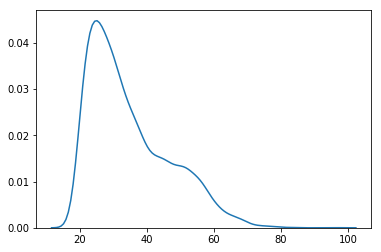

In [10]:
import seaborn as sns
display(compas.head(3).T)
sns.kdeplot(np.array(compas_raw.age))
plt.show()

## Generate synthetic data set

In the chunk below, we generate the synthetic data as described by Lakkaraju et al.

**Variables**

* M = number of judges
* subj = number of subjects assigned to each judge
* betas $\beta$ are coefficients
* R = acceptance rates
* X = invidual's features observable to all (models and judges)
* Z = information observable for judges only
* W = unobservable / inaccessible information
* T = decisions

In [11]:
import numpy.random as npr

npr.seed(0)

nJudges_M = 100
nSubjects_N = 500

beta_X = 1.0
beta_Z = 1.0
beta_W = 0.2

judgeID_J = np.repeat(np.arange(0, nJudges_M, dtype = np.int32), nSubjects_N)

acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

acceptanceRate_R = np.repeat(acceptance_rates, nSubjects_N)

X = npr.normal(size = nJudges_M * nSubjects_N)
Z = npr.normal(size = nJudges_M * nSubjects_N)
W = npr.normal(size = nJudges_M * nSubjects_N)

probabilities_Y = 1 / (1 + np.exp(-(beta_X * X + beta_Z * Z + beta_W * W)))

# 0 if P(Y = 0| X = x;Z = z;W = w) >= 0.5 , 1 otherwise
result_Y = 1 - probabilities_Y.round()

probabilities_T = 1 / (1 + np.exp(-(beta_X * X + beta_Z * Z)))
probabilities_T += npr.normal(0, .1, nJudges_M * nSubjects_N)

decision_T = np.zeros(nJudges_M * nSubjects_N) - 1

tmp = pd.DataFrame(np.column_stack((judgeID_J, acceptanceRate_R, X,
                                    Z, W, result_Y, probabilities_T, decision_T)),
                   columns = ["judgeID_J", "acceptanceRate_R", "X",
                              "Z", "W", "result_Y", "probabilities_T", "decision_T"])

# Sort by judges then probabilities
df = tmp.sort_values(by = ["judgeID_J", "probabilities_T"], ascending = False)

# Iterate over the data. Subject is in the top (1-r)*100% if
# his within-judge-index is over acceptance threshold times
# the number of subjects assigned to each judge. If subject
# is over the limit they are assigned a zero, else one.
for i in range(nJudges_M * nSubjects_N):
    index = i % nSubjects_N
    if index < (1 - df.acceptanceRate_R[i]) * nSubjects_N:
        df.decision_T[i] = 0
    else:
        df.decision_T[i] = 1  # TARKISTA!!!!!!

Basic stats of the created data set.  We see that sensitivity is XX% and specifity YY%.

In [12]:
print(df.decision_T.value_counts())

tab = df.groupby(['result_Y', 'decision_T']).size()
tab.unstack()

0.0    26137
1.0    23863
Name: decision_T, dtype: int64


decision_T    0.0    1.0
result_Y                
0.0         13119  12056
1.0         13018  11807

In [13]:
# Shuffle and split data set to test and train
train, test = np.split(df.sample(frac = 1, random_state = 0), 2)

print(train.shape)
print(test.shape)

train_labeled = train[train.decision_T == 1]
test_labeled = test[test.decision_T == 1]

print(train_labeled.shape)
print(test_labeled.shape)

tab = train_labeled.groupby(['result_Y', 'decision_T']).size()
tab.unstack()

(25000, 8)
(25000, 8)
(12059, 8)
(11804, 8)


decision_T   1.0
result_Y        
0.0         6105
1.0         5954

In his report Lakkaraju says that they used logistic regression.

### Machine evaluation

Next we train a logistic regression to predict the ...

In [14]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_machine = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
logreg_machine.fit(train_labeled.X.values.reshape(-1,1), train_labeled.result_Y)

# predict probabilities and attach to data 
label_probabilities_machine = logreg_machine.predict_proba(test.X.values.reshape(-1,1))

test['B_prob_0_machine'] = label_probabilities_machine[:, 0]
test['B_prob_1_machine'] = label_probabilities_machine[:, 1]

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_labeled.X.values.reshape(-1,1), train_labeled.result_Y)

preds = clf.predict_proba(test.X.values.reshape(-1,1))

test['B_prob_0_tree'] = preds[:, 0]

## Implementation of contraction algorithm

Below is an implementation of Lakkaraju's team's algorithm presented in [their paper](https://helka.finna.fi/PrimoRecord/pci.acm3098066). Relevant parameters to be passed to the fucntion are presented in the description.

In [15]:
def contraction(df, judgeIDJ_col, decisionT_col, resultY_col, modelProbS_col, accRateR_col, r, binning = False):
    '''
    This is an implementation of the algorithm presented by Lakkaraju
    et al. in their paper "The Selective Labels Problem: Evaluating 
    Algorithmic Predictions in the Presence of Unobservables" (2017).
    
    Parameters:
    df = The (Pandas) data frame containing the data, judge decisions,
    judge IDs, results and probability scores.
    judgeIDJ_col = String, the name of the column containing the judges' IDs
    in df.
    decisionT_col = String, the name of the column containing the judges' decisions
    resultY_col = String, the name of the column containing the realization
    modelProbS_col = String, the name of the column containing the probability
    scores from the black-box model B.
    accRateR_col = String, the name of the column containing the judges' 
    acceptance rates
    r = Float between 0 and 1, the given acceptance rate.
    binning = Boolean, should judges with same acceptance rate be binned
    
    Returns:
    u = The estimated failure rate at acceptance rate r.
    '''
    # Sort first by acceptance rate and judge ID.
    sorted_df = df.sort_values(by = [accRateR_col, judgeIDJ_col], ascending = False)

    if binning:
        # Get maximum leniency
        max_leniency = sorted_df[accRateR_col].values[0].round(1)

        # Get list of judges that are the most lenient
        most_lenient_list = sorted_df.loc[sorted_df[accRateR_col].round(1) == max_leniency, judgeIDJ_col]

        # Subset to obtain D_q
        D_q = sorted_df[sorted_df[judgeIDJ_col].isin(most_lenient_list.unique())]
    else:
        # Get most lenient judge
        most_lenient_ID = sorted_df[judgeIDJ_col].values[0]
        
        # Subset
        D_q = sorted_df[sorted_df[judgeIDJ_col] == most_lenient_ID]
    
    R_q = D_q[D_q[decisionT_col] == 1]

    R_sort_q = R_q.sort_values(by = modelProbS_col, ascending = False)

    number_to_remove = int(np.round((1 - r) * D_q.shape[0] - (D_q.shape[0] - R_q.shape[0])))

    R_B = R_sort_q[number_to_remove:R_sort_q.shape[0]]

    return np.sum(R_B[resultY_col] == 0) / D_q.shape[0]

### Validation analysis

Below we try to replicate the results obtained by Lakkaraju et alii in their paper linked above.

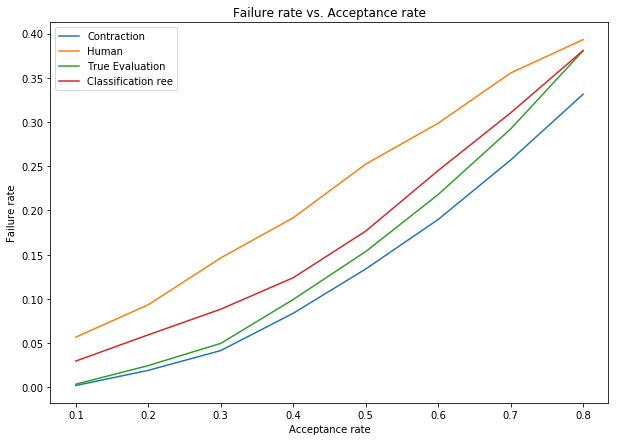

[[0.00197628 0.05670447 0.0034227  0.02964427]
 [0.01910408 0.09335408 0.02452938 0.05928854]
 [0.04150198 0.14629259 0.04962921 0.08827404]
 [0.08366271 0.19167265 0.09925841 0.12384717]
 [0.13372859 0.25233309 0.15345123 0.17654809]
 [0.18972332 0.29859214 0.21791215 0.24505929]
 [0.256917   0.35540211 0.29207074 0.31027668]
 [0.33135705 0.39316675 0.38049059 0.38076416]]


In [16]:
failure_rates = np.zeros((8, 4))

for r in np.arange(1, 9):
    failure_rates[r-1, 0] = contraction(test[test.decision_T==1], 'judgeID_J', 'decision_T',
                                   'result_Y', 'B_prob_0_machine', 'acceptanceRate_R',  r / 10, True)

    ## Human error rate - Jotain väärin viel'
    # Get judges with correct leniency as list
    correct_leniency_list = test.judgeID_J[test['acceptanceRate_R'].round(1) == r / 10]
    
    # Released are the people they judged and released, T = 1
    released = test[test.judgeID_J.isin(correct_leniency_list) & (test.decision_T == 1)]
    
    #print(released.shape, correct_leniency_list.shape[0], released.result_Y.value_counts())
    # Get their failure rate, aka ratio of reoffenders to number of people judged in total
    failure_rates[r-1, 1] = np.sum(released.result_Y == 0) / correct_leniency_list.shape[0]

    ## True evaluation
    failure_rates[r-1, 2] = contraction(test, 'judgeID_J', 'decision_T',
                                   'result_Y', 'B_prob_0_machine', 'acceptanceRate_R',  r / 10, True)
    ## Dec tree
    failure_rates[r-1, 3] = contraction(test[test.decision_T==1], 'judgeID_J', 'decision_T',
                                   'result_Y', 'B_prob_0_tree', 'acceptanceRate_R',  r / 10, True)
    

# klassifikaatioille scity.stats semin kautta error bati xerr ja yerr argumentttien kautta    

plt.figure(figsize=(10,7))
plt.plot(np.arange(0.1,0.9,.1), failure_rates[:,0], label = 'Contraction')
plt.plot(np.arange(0.1,0.9,.1), failure_rates[:,1], label = 'Human')
plt.plot(np.arange(0.1,0.9,.1), failure_rates[:,2], label = 'True Evaluation')
plt.plot(np.arange(0.1,0.9,.1), failure_rates[:,3], label = 'Classification ree')

plt.title('Failure rate vs. Acceptance rate')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.show()
print(failure_rates)

## Implementation of our model

As defined in somewhere, our model is defined by the probabilistic expression $$ P(Y=0 | \text{do}(R=r)) = \sum_x P(Y=0|R=r, X=x, T=1)P(T=1|R=r, X=x)P(X=x)$$

we approximate $P(X=x)$ with <!--frequencies and **Gaussian kernel**.-->

In [17]:
# instantiate the model (using the default parameters)
lr_causal_decision = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
lr_causal_decision.fit(train[['acceptanceRate_R', 'X']].values.reshape(-1,2), train.decision_T)

lr_causal_result = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
lr_causal_result.fit(train_labeled[['acceptanceRate_R', 'X']].values.reshape(-1,2), train_labeled.result_Y)

#def causal_probs(r, df, resultY_col, decisionT_col, x_cols):
#    tmp = pd.DataFrame({'acceptanceRate_R' : r * df.shape[0], 'X' : x_cols})
#    result_probs = lr_causal_result.predict_proba(tmp)[:,0]
#    decision_probs = lr_causal_decision.predict_proba(tmp)[:,0]
#    

my = np.mean(test.X)
sigma = np.var(test.X)

display(test.head(6))

max_r = max(test.acceptanceRate_R)

print(test.loc[(test.acceptanceRate_R.round(1) == 0.8) & (test.X.round(1) == 0.1), 'decision_T'].value_counts())

print(test.loc[(test.acceptanceRate_R.round(1) == 0.8) & \
               (test.X.round(1) == 0.1) & \
               (test.decision_T == 1), 'result_Y'].value_counts())

judgeID_J  acceptanceRate_R         X         Z         W  result_Y  \
28213       56.0          0.622487  1.863196 -1.305263  0.646700       0.0   
45271       90.0          0.354855  0.928180  1.103123 -1.695381       0.0   
46254       92.0          0.205438  2.324192  0.142582 -0.455072       0.0   
27799       55.0          0.229048 -0.428510  0.093301 -0.314322       1.0   
32158       64.0          0.257266  1.031424 -0.625772  0.327365       0.0   
14483       28.0          0.517479  0.036196  1.109770 -1.484993       0.0   

       probabilities_T  decision_T  B_prob_0_machine  B_prob_1_machine  \
28213         0.725045         1.0          0.958488          0.041512   
45271         0.951794         0.0          0.830737          0.169263   
46254         0.676108         0.0          0.980215          0.019785   
27799         0.530956         0.0          0.341636          0.658364   
32158         0.638528         0.0          0.853440          0.146560   
14483         0.633938         1.0          0.528371          0.471629   

       B_prob_0_tree  
28213            1.0  
45271            1.0  
46254            1.0  
27799            1.0  
32158            1.0  
14483            0.0

1.0    61
0.0    18
Name: decision_T, dtype: int64
0.0    41
1.0    20
Name: result_Y, dtype: int64
